In [1]:
import pandas as pd
from Bio import AlignIO
import os
import matplotlib.pyplot as plt

In [5]:
kinases = pd.read_csv('../datasets/kinases.tsv', sep= '\t')
kinases.columns = kinases.columns.str.lower()

In [6]:
path = '../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/'

In [4]:
#align = AlignIO.read(open('../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/P00519_clustalO_fullidentity_all.fasta.aln'), format= 'fasta')
#len(align) # hacer una distribucion

# Distribution seqs/MSA

In [7]:
def seqs_per_msa(path):
    '''
    returns a DataFrame with number of sequences in each MSA
    path: path to folder containing MSA files
    '''
    # iterate over the MSA files
    seqs_msa = {}
    l = []
    no_errors = 0
    i = 0
    for filename in os.listdir(path):
        f = os.path.join(path, filename) # is the complete path to each msa

        if os.path.isfile(f):
            
            # Check if file is empty
            check_file = os.stat(f).st_size
            if check_file != 0:
                msa_name = filename.split(".")[0].split("_")
                msa_name = msa_name[0] + "_" + msa_name[3]
                # align objects can be treated as lists of SeqRecord objects
                align = AlignIO.read(open(f), format= 'fasta')
                for record in align:
                    try:
                        l.append([msa_name, record.id, len(record)])
                        #print("%s %i" % (record.id, len(record)))
                        seqs_msa[msa_name] = len(align)
                        # to dataframe
                        
                        i += 1
                    except:
                        print(f"error in file {filename}")
                        no_errors += 1
    df = pd.DataFrame.from_dict(seqs_msa, orient= 'index').reset_index().rename(columns= {'index': 'msa', 0: 'no_seqs'})
    return df, l

In [8]:
seqs_msa, l = seqs_per_msa(path= '../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/')
seqs_msa

,msa,no_seqs
0,A0A2I0BVG8_60,6
1,A0A2I0BVG8_80,5
2,A0A2I0BVG8_all,45
3,A0A509AFG4_60,6
4,A0A509AFG4_80,2
...,...,...
744,Q9ZV15_80,3
745,Q9ZV15_all,77
746,W7JX98_60,5
747,W7JX98_80,5


<AxesSubplot:>

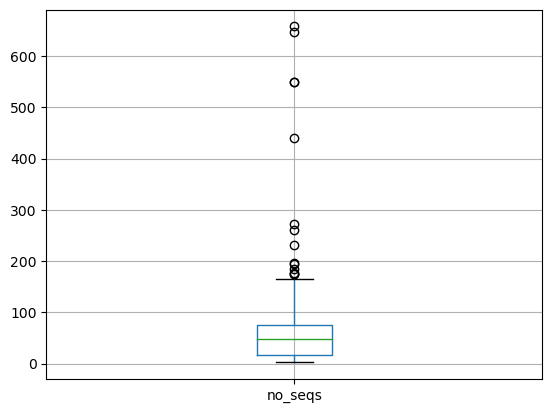

In [10]:
seqs_msa.boxplot()

In [14]:
def plot_distrib_msa(data, threshold= 'all'):
    threshold = str(threshold)
    data[data.msa.str.endswith(threshold)].no_seqs.plot(kind= 'hist', bins= 50, color= 'gray', edgecolor= 'black')
    plt.title(f"Distribution #seqs/MSA\nthreshold = {threshold}")
    plt.ylabel("# MSAs")
    plt.xlabel('# sequences')
    plt.show()

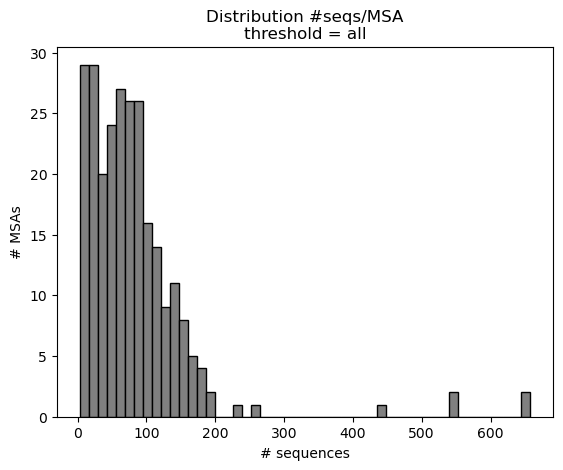

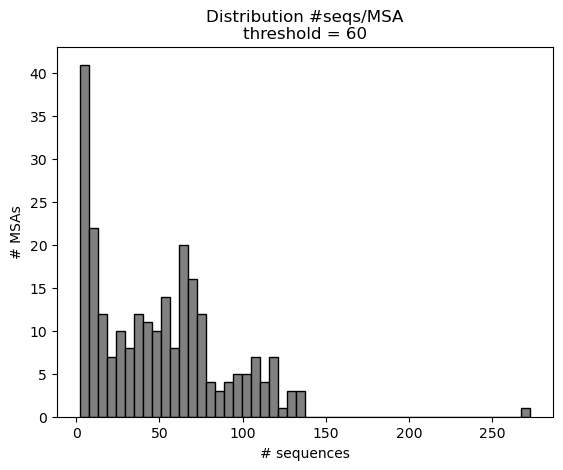

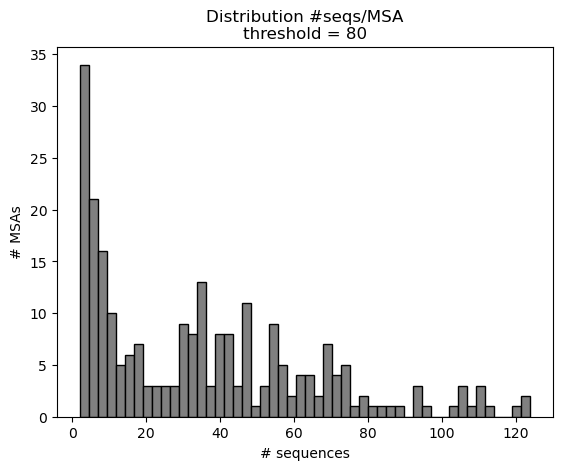

In [17]:
plot_distrib_msa(data= seqs_msa)
plot_distrib_msa(data= seqs_msa, threshold=60)
plot_distrib_msa(data= seqs_msa, threshold=80)

# Orthologs overlap

In [9]:
all_msas = pd.DataFrame(l, columns= ['msa', 'uniprot', 'length_msa'])
all_msas

,msa,uniprot,length_msa
0,A0A2I0BVG8_60,A0A2I0BVG8,536
1,A0A2I0BVG8_60,A0A0D9QJY8,536
2,A0A2I0BVG8_60,A0A0L7M8D5,536
3,A0A2I0BVG8_60,A0A1Y3DU95,536
4,A0A2I0BVG8_60,A5KBU9,536
...,...,...,...
42143,W7JX98_all,R7TJP2,1377
42144,W7JX98_all,T1J2D2,1377
42145,W7JX98_all,U3KFF9,1377
42146,W7JX98_all,W2SK18,1377


In [10]:
# Subset the MSAs
all = all_msas[all_msas.msa.str.endswith("all")]
msa_60 = all_msas[all_msas.msa.str.endswith("60")]
msa_80 = all_msas[all_msas.msa.str.endswith("80")]

In [11]:
# list with kinases reference proteins
kin = kinases.uniprot.unique().tolist()

In [12]:
# Create sets with unique proteins in each msa
all = all.groupby("msa").agg({'uniprot': lambda x: x.tolist()}).reset_index()
all

,msa,uniprot
0,A0A2I0BVG8_all,"[A0A2I0BVG8, A0A023B173, A0A0C2IKB7, A0A0D9QJY..."
1,A0A509AFG4_all,"[A0A509AFG4, A0A015KQ67, A0A059J0T9, A0A0D9QSD..."
2,A0A509AHB6_all,"[A0A509AHB6, A0A023B173, A0A0C2IKB7, A0A0D2VHA..."
3,A0A509AKL0_all,"[A0A509AKL0, A0A023B252, A0A061DD08, A0A068Y9V..."
4,A0A509AQE6_all,"[A0A509AQE6, A0A015K587, A0A023BCV0, A0A061DD0..."
...,...,...
252,Q9ZSA3_all,"[Q9ZSA3, A0A087GM80, B6EP77, G8JN52, K5BI95, M..."
253,Q9ZSA4_all,"[Q9ZSA4, A0A0L8ICP1, A0A668RKR5, A3DEI9, C4Y9R..."
254,Q9ZUZ2_all,"[Q9ZUZ2, A0A059C0N6, A0A061CZ84, A0A061DU80, A..."
255,Q9ZV15_all,"[Q9ZV15, A0A059DJ09, A0A068UQL6, A0A087H3U3, A..."


In [13]:
def find_overlaps(df, refers):
    '''
    df: dataframe containing MSAs and list of proteins in each one
    refers: list containing reference proteins for checking overlap
    returns dataframe with MSA name, list of proteins in that MSA and list of reference
    proteins in that MSA
    '''
    # Create lists with proteins in each msa
    df = df.groupby("msa").agg({'uniprot': lambda x: x.tolist()}).reset_index()
    df["overlap"] = [ [] for _ in range(len(df))]
    for ix in df.index:
        lst = df.uniprot[ix][1:] # exclude the first because is the reference
        for kinase in refers:
            if kinase in lst:
                df["overlap"][ix].append(kinase)
    return df

In [41]:
# Ok. tested
def plot_overlap(msa, refers, title, color= 'royalblue', bins= 6):
    '''
    plot overlaping reference proteins in MSAs 
    '''
    df = find_overlaps(msa, refers)
    df.overlap.apply(lambda x: len(x)).plot(
    kind= 'hist',
    color= color,
    edgecolor= 'black',
    bins= bins
    )
    plt.title(title)
    plt.xlabel("# proteins")
    plt.show()


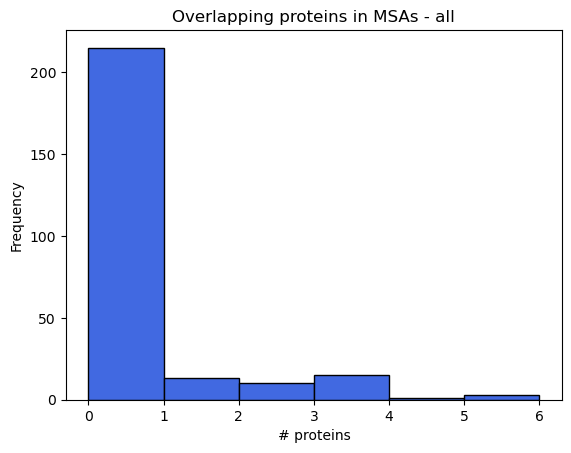

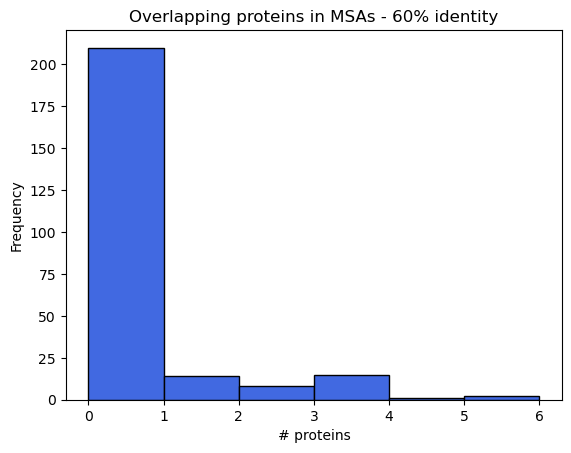

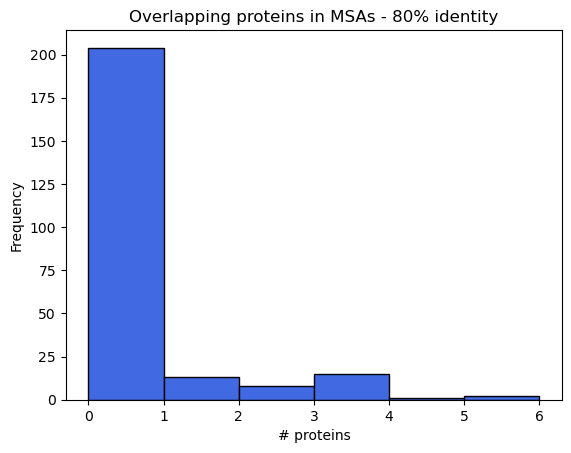

In [35]:
plot_overlap(all, refers= kin, title= "Overlapping proteins in MSAs - all")
plot_overlap(msa_60, refers= kin, title= "Overlapping proteins in MSAs - 60% identity")
plot_overlap(msa_80, refers= kin, title= "Overlapping proteins in MSAs - 80% identity")

---

### select one msa for gap strip and seq2logo

In [14]:
all_msas

,msa,uniprot,length_msa
0,A0A2I0BVG8_60,A0A2I0BVG8,536
1,A0A2I0BVG8_60,A0A0D9QJY8,536
2,A0A2I0BVG8_60,A0A0L7M8D5,536
3,A0A2I0BVG8_60,A0A1Y3DU95,536
4,A0A2I0BVG8_60,A5KBU9,536
...,...,...,...
42143,W7JX98_all,R7TJP2,1377
42144,W7JX98_all,T1J2D2,1377
42145,W7JX98_all,U3KFF9,1377
42146,W7JX98_all,W2SK18,1377


---

# Mapping PDBs to orthologs 

In [2]:
sift = pd.read_csv(
    '../datasets/uniprot_segments_observed.tsv.gz',
    sep= '\t',
    compression= 'gzip',
    skiprows= 1
)
sift.columns = sift.columns.str.lower()

In [3]:
# Mapping: pdbs for each uniprot
pdb_uniprot = sift[['pdb', 'sp_primary']].drop_duplicates().rename(columns= {'sp_primary': 'uniprot_acc'})
pdb_uniprot

,pdb,uniprot_acc
0,121p,P01112
1,132l,P00698
2,133l,P61626
3,129l,P00720
4,139l,P00720
...,...,...
977587,6eae,P03420
977589,6e9p,P9WFY1
977591,6e9p,P9WFX9
977601,6eaf,P03420


In [15]:
# Get list of orthologs
ortho = all_msas.uniprot.unique().tolist()

In [16]:
len(ortho)

13652

In [19]:
# How many orthologs proteins have pdb structure
pdb_orthologs = pdb_uniprot[pdb_uniprot.uniprot_acc.isin(ortho)]
pdb_orthologs

,pdb,uniprot_acc
965,1gag,P06213
1044,1gzo,P31751
1234,1i35,P28829
1237,1i44,P06213
1986,1m17,P00533
...,...,...
976383,7urz,Q13554
976469,7pg4,P06213
976493,7pg3,P06213
977452,7up8,O75582


In [36]:
pdb_orthologs.pdb[:10].to_list()

['1gag',
 '1gzo',
 '1i35',
 '1i44',
 '1m17',
 '1nvr',
 '1o6l',
 '1ow8',
 '1prl',
 '1qty']

In [20]:
f"{pdb_orthologs.uniprot_acc.nunique()} out of {len(ortho)} ortholog proteins have PDB structure"

'126 out of 13652 ortholog proteins have PDB structure'

## How many of them in MSAs?

In [30]:
all_msas["msa_ref"] = all_msas.msa.str.split("_")
all_msas["msa_ref"] = all_msas["msa_ref"][0]

ValueError: Length of values (2) does not match length of index (42148)

In [29]:
"A0A2I0BVG8_all".split("_")[0]

'A0A2I0BVG8'

In [34]:
all_msas[all_msas.uniprot.isin(pdb_orthologs.uniprot_acc)]#.uniprot.nunique()

,msa,uniprot,length_msa,msa_ref
46,A0A2I0BVG8_all,Q3HNM6,1126,"[A0A2I0BVG8, all]"
139,A0A509AHB6_all,Q3HNM6,1136,"[A0A509AHB6, all]"
518,A5K0N4_60,A5K0N4,923,"[A5K0N4, 60]"
524,A5K0N4_60,Q8I719,923,"[A5K0N4, 60]"
527,A5K0N4_80,A5K0N4,851,"[A5K0N4, 80]"
...,...,...,...,...
40967,Q9UIK4_80,Q9UIK4,391,"[Q9UIK4, 80]"
40996,Q9UIK4_all,Q9UIK4,739,"[Q9UIK4, all]"
41088,Q9Y243_60,Q9Y243,584,"[Q9Y243, 60]"
41180,Q9Y243_80,Q9Y243,515,"[Q9Y243, 80]"


---

### df with regions (KDs and CREs)  
for calculate regions MSAs using homology transfer pipeline

In [2]:
kinases = pd.read_csv('../datasets/kinases.tsv', sep= '\t')
kinases.columns = kinases.columns.str.lower().str.replace(" ", "_")
kinases = kinases.rename(columns= {'uniprot': 'uniprot_acc', 'cre_(start)': 'cre_start', 'cre_(end)': 'cre_end', 'kd_(start)': 'kd_start', 'kd_(end)': 'kd_end'})
kinases

,uniprot_acc,organism,cre_start,cre_end,cre_(s_or_d),length,kd_start,kd_end,pdb_id,pdb_res_(å),af,status
0,A0A2I0BVG8,P. falciparum (isolate NF54),346,353,no,NaN,56,325,no,no,AF-A0A2I0BVG8-F1,new
1,A0A509AFG4,P. berghei (strain Anka),385,393,no,NaN,110,365,no,no,AF-A0A509AFG4-F1,new
2,A0A509AHB6,P. berghei (strain Anka),345,352,no,NaN,57,324,no,no,AF-A0A509AHB6-F1,new
3,A0A509AKL0,P. berghei (strain Anka),1,33,no,NaN,545,802,no,no,AF-A0A509AKL0-F1,new
4,A0A509AQE6,P. berghei (strain Anka),394,402,no,NaN,118,372,no,no,AF-A0A509AQE6-F1,new
...,...,...,...,...,...,...,...,...,...,...,...,...
297,Q9ZSA4,A. thaliana,295,325,no,NaN,28,290,no,no,AF-Q9ZSA4-F1,new
298,Q9ZUZ2,A. thaliana,409,439,no,NaN,143,405,no,no,AF-Q9ZUZ2-F1,new
299,Q9ZV15,A. thaliana,398,428,no,NaN,134,392,no,no,AF-Q9ZV15-F1,new
300,W0LYS5,M. nipponense,287,327,no,NaN,31,287,no,no,AF-W0LYS5-F1,new


In [3]:
kd = kinases[['uniprot_acc', 'kd_start', 'kd_end']].drop_duplicates().rename(
    columns= {
        'kd_start': 'start',
        'kd_end': 'end'
    }
)
ids = [ "kd" + str(i) for i in range(1, len(kd)+1) ]
kd['term_id'] = ids

In [58]:
#kd.to_csv('../datasets/kd.tsv', sep= '\t', index= False)

In [4]:
kd

,uniprot_acc,start,end,term_id
0,A0A2I0BVG8,56,325,kd1
1,A0A509AFG4,110,365,kd2
2,A0A509AHB6,57,324,kd3
3,A0A509AKL0,545,802,kd4
4,A0A509AQE6,118,372,kd5
...,...,...,...,...
297,Q9ZSA4,28,290,kd282
298,Q9ZUZ2,143,405,kd283
299,Q9ZV15,134,392,kd284
300,W0LYS5,31,287,kd285


In [5]:
cre = kinases[['uniprot_acc', 'cre_start', 'cre_end']].drop_duplicates().rename(
    columns= {
        'cre_start': 'start',
        'cre_end': 'end'
    }
)
ids = [ "cre" + str(i) for i in range(1, len(cre)+1) ]
cre['term_id'] = ids

In [64]:
#cre.to_csv('../datasets/cre.tsv', sep= '\t', index= False)

In [6]:
regions = pd.concat([kd, cre], ignore_index= True)

In [7]:
#regions.to_csv('../datasets/regions.txt', sep= '\t', index= False)